# Little Theory Please..

Note is a single Pitch while Chord is a group of notes. A note consists of Pitch (frequency), Octave (which set of pitches), and Offset(location of the note). 
 
Pickle: It converts python object into a byte stream to store it in a file or a database. 

We will be ignoring the duration , and will consider that interval between two 
consecutive nodes is 0.5 units

Approach : The approach for music generation is going to be very similar to that of text generation using lstm. 

MIDI file for a music contains all the information about the different notes, chords , their location and duration. We will be exploiting this information. We will take a sliding window of size SEQUENCE_LENGTH, and for every window the targeted output is going to be the next note's pitch that was actually there in the audio. We will store all such input and target in a list, on which the model would be trained. Our model would learn the next_note to pe predicted given a sequence of notes. So effectively our model would consider previous {SEQUENCE_LENGTH} notes to predict the next note. 

During Prediction time we will randomly choose a starting window from our dataset, and will continue to slide the window using kick-out methodology of FIFO and will continue to add the newly predicted note in our window, so as to maintain the window size.


NOTE: The size of the model is okayish type due to moderate amount of data.    


#1- Import Modules

In [9]:
%%capture
!pip install pyfluidsynth
print("Here1")
!pip uninstall pyfluidsynth
print("Here1")

!pip install --upgrade pyfluidsynth
!pip install -Iv https://pypi.python.org/packages/source/p/pyFluidSynth/pyFluidSynth-1.2.4.tar.gz#md5=60079310701d0b9298b65a8b6728ffcc
print("Here1")
!pip install pretty_midi

Using pip 23.0.1 from C:\Users\abdul\anaconda3\envs\fyp\lib\site-packages\pip (python 3.9)
  Using cached https://pypi.python.org/packages/source/p/pyFluidSynth/pyFluidSynth-1.2.4.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyFluidSynth: filename=pyFluidSynth-1.2.4-py3-none-any.whl size=4666 sha256=111454155e2df4449783319b39b73e32c6635b3c0328e2282eefd56bc0d4b264
  Stored in directory: c:\users\abdul\appdata\local\pip\cache\wheels\04\f8\27\db62229cac967573189494795a57d82b16451d317b931dded5
Successfully built pyFluidSynth
Here1


  Running command python setup.py egg_info
  Running command python setup.py bdist_wheel
  C:\Users\abdul\anaconda3\envs\fyp\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(


In [14]:
!pip uninstall pyfluidsynth

^C


In [15]:
%%capture

import os 
import pickle 
import numpy as np
import fluidsynth
import pretty_midi
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from music21 import converter, instrument, note, chord, stream
from IPython.display import Audio, display, Image
from matplotlib import pyplot as plt
%matplotlib inline

#2- Feel the Dataset Music

In [16]:

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    """
    This function takes a pretty_midi object and plays the audio file for 30 secs.
    Args : 
        pretty_midi object, and duration
    Returns: 
        Plays the audio
    
    """
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display(Audio(waveform_short, rate=_SAMPLING_RATE))

In [17]:
#Set the random seed so as to get constant results. 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback, and sequence_length of the window . 
_SAMPLING_RATE = 44100
SEQUENCE_LENGTH = 50

In [18]:
#play the music to get the feel of the training data. 
pm = pretty_midi.PrettyMIDI('project/foleygen/music/midi_songs/FF4.mid')
display_audio(pm)

AttributeError: module 'fluidsynth' has no attribute 'Synth'

#3- Read Midi files 
We read midi file one by one and extract out notes from it and append to our 'notes' array. If it contains chord, we append by encoding id of every node sepeared by a dot. 

NOTE: Run this section only if you want to retrain the model, or something has been changed, otherwise simply to generate new sounds jump to section 5

##3.1 Read and store in list

In [ ]:
MIDI_FILES_DIR = '/content/drive/MyDrive/project/autofoley/music/midi_songs/'

In [ ]:
def read_midi():
    """
    This function reads all the files (should be .mid) in MIDI_FILES_DIR, 
    and find out and separate the piano instrument notes, and append their pitches to the array.
    If the sound happen to be a chord , we encode id of every node in the chord together into a single string, with each note separated by a dot. 
    Args : 
        None
    Returns : 
        notes : pitch of notes of all the files in MIDI_FILES_DIR directory.
    """
    midi_all_files = os.listdir(MIDI_FILES_DIR)
    notes = []
    for file in midi_all_files:
        midi_file = f'{MIDI_FILES_DIR}/{file}'
        midi = converter.parse(midi_file)
        notes_to_parse = None

        parts = instrument.partitionByInstrument(midi)

        #If file contains instrument parts, seperate out the piano class, which is 0th part. 
        if parts:
            notes_to_parse = parts.parts[0].recurse()
        else : #file contain notes in a flat structure not in recursive way
            notes_to_parse = midi.flat.notes
        
        for element in notes_to_parse:
            if(isinstance(element, note.Note)):
                notes.append(str(element.pitch))
            elif(isinstance(element, chord.Chord)):
                notes.append('.'.join(str(note) for note in element.normalOrder))
    
    return notes

In [ ]:
midi_notes = read_midi()

#Save the notes for future use
with open(f'/content/drive/MyDrive/project/autofoley/music/notes', 'wb') as filepath:
    pickle.dump(midi_notes, filepath)

In [ ]:
music_vocab = set(midi_notes)
n_vocab = len(music_vocab)

#4- Prepare Dataset and Create Model

Our model won't understand the string data, so we need to convert the string data to numerical data. 
We want to train our model like this , we will give it a sequence of notes, and it will try to predict the next notes/chord in our sequence. 
This is just like predicting the next word while generating the sequences . 

So while making the predictions we will be considering the previous {SEQUENCE_LENGTH} inputs. 

NOTE: Run this section only if you want to retrain the model, or something has been changed, otherwise simply to generate new sounds jump to section 5

##4.1 Prepare Dataset - Convert notes to ints

In [ ]:
def prepare_sequence(notes, n_vocab):
    """
    This function converts the notes strings into numbers.
    To get the X, we use a kind of sliding windown approach to get each number in the SEQ_LEN Window and keep shifing the window
    Y, is the element next to the current window, i.e our target number.  
    Args : 
        notes : our notes array generated from the midi files, which contains pitches and chords of the song.
        n_vocab : Unique notes/chords present in our notes
    returns : 
        {network_in, network_out}, i.e every window of size SEQ_LEN and corresponding next element.   
    """

    #get all the pitches in our notes
    pitch_names = sorted(set(notes))

    #create dictonary (key:val), where key = pitch and val = integer
    note_to_int_dict = dict((note, counter) for counter, note in enumerate(pitch_names)) 

    #network_input contains list of list of (SEQ_LEN of integers)
    #network_output contains ki network_input[i] sequence's next note(integer)
    network_input = []
    network_output = []

    for i in range(len(notes) - SEQUENCE_LENGTH):
        input_notes = notes[i:i+SEQUENCE_LENGTH]
        next_note = notes[i+SEQUENCE_LENGTH]

        network_input.append([note_to_int_dict[k] for k in input_notes])
        network_output.append(note_to_int_dict[next_note])
    
    n_patterns = len(network_input)

    #Convert the input compactible with the LSTM layer, where each example passed to each lstm
    network_input = np.reshape(network_input, (n_patterns, SEQUENCE_LENGTH, 1))
    #normalize
    network_input = network_input/float(n_vocab)

    #Convert to one_hot vectors
    network_output = to_categorical(network_output)

    return (network_input, network_output); 


In [ ]:
X_train, Y_train = prepare_sequence(midi_notes, n_vocab)

##4.2 Create, Train the model

In [ ]:
def create_music_model(network_input, n_vocab):
    model = Sequential()
    model.add(LSTM(128, input_shape = (network_input.shape[1], network_input.shape[2]), recurrent_dropout=0.4, return_sequences = True))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.5))
    model.add(LSTM(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_vocab, activation = 'softmax'))

    return model

## Note : Run below only If you want to retrain the model, else directly load the model . 

If want to continue training from where left previously, load the saved model, else create the model

In [ ]:
# music_model = load_model('/content/drive/MyDrive/project/autofoley/music/trained_model/music_model.h5')
#else 

#music_model = create_music_model(X_train, n_vocab)

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/project/autofoley/music/trained_model/music_model.h5"

batch_size = 128

# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = 'min',
    verbose=1,
    save_best_only = True)

# Train the model with the new callback
music_model.fit(X_train, 
          Y_train,
          epochs=60, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          verbose=1)

# 5- Generating Music

##5.1 Load the saved model and notes

In [ ]:
music_model = load_model('/content/drive/MyDrive/project/autofoley/music/trained_model/music_model.h5')
with open('/content/drive/MyDrive/project/autofoley/music/notes', 'rb') as filepath:
    loaded_midi_notes = pickle.load(filepath)

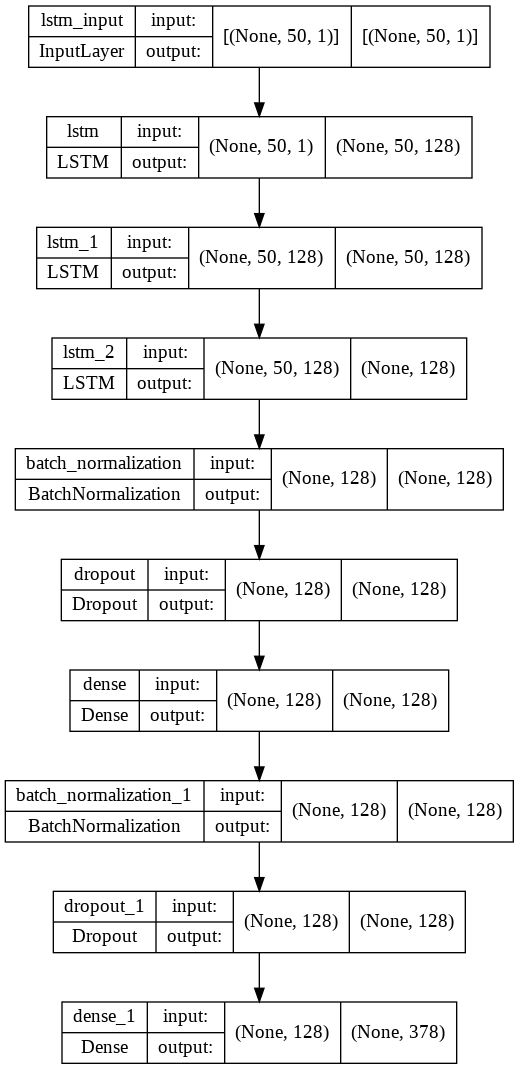

In [ ]:
#Show how our model looks like. 
plot_model(music_model, to_file = 'music_model_structure_plot.png', show_shapes = True, show_layer_names= True)

In [ ]:
music_vocab = set(loaded_midi_notes)
n_vocab = len(music_vocab)
pitch_names = sorted(music_vocab)

## 5.2 Generate predicted sequence

In [ ]:
def generate_input(notes, n_vocab, pitch_names):
    """
    This function generates the network_input. Could be clubbed together with prepare_sequence function.
    But as my model has got trained, so I don't want to retrain it. 
    Args:
        notes : list of list of notes of all windows
        n_vocab: count of different notes in our data
        pitch_names : list of all unique pitches notes in our data.

    Returns: 
        network_input: input windows for our model
    """
    note_to_int_dict = dict((note, counter) for counter, note in enumerate(pitch_names)) 
    network_input = []
    for i in range(len(notes) - SEQUENCE_LENGTH):
        input_notes = notes[i:i+SEQUENCE_LENGTH]
        network_input.append([note_to_int_dict[k] for k in input_notes])
    
    return network_input 



def generate_music_notes(model, how_many_notes, network_input, pitch_names, n_vocab):
    """
    This function randomly choose a starting point, and predict the next note using the model.Then window is slid to make next prediction. 
    Args:
        model : model to be used for prediction 
        how_many_notes: how many notes to be generated 
        network_input : input to model
        pitch_names : unique pitches notes 
        n_vocab : count of unique notes

    Returns:
        list of generated sequence (1-hot encoded)
    """

    int_to_note_dict = dict((counter, note) for counter, note in enumerate(pitch_names))

    random_start_point = np.random.randint(0, len(network_input)-1)

    pattern = network_input[random_start_point]
    generated_notes = []

    for notes_counter in range(how_many_notes):
        reshaped_input = np.reshape(pattern, (1, len(pattern), 1))
        normalized_input = reshaped_input / float(n_vocab)

        predicted_next_seq = np.argmax(model.predict(normalized_input, verbose = 0))
        # predicted_next_seq = np.random.choice(Y_train.shape[1], 1, p=model.predict(normalized_input, verbose = 0)[0])[0]

        predicted_next_note = int_to_note_dict[predicted_next_seq]

        generated_notes.append(predicted_next_note)

        pattern = pattern[1:]
        pattern.append(predicted_next_seq)
    
    return generated_notes


In [ ]:
network_input = generate_input(loaded_midi_notes, n_vocab, pitch_names)

#generate seq
generated_music_note = generate_music_notes(music_model,500, network_input, pitch_names, n_vocab)

##5.3 Convert generate sequence to midi files 

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

In [ ]:
create_midi(generated_music_note)

##5.4 Save helpers

In [ ]:
music_helpers = [SEQUENCE_LENGTH, network_input, loaded_midi_notes]

with open(f'/content/drive/MyDrive/project/autofoley/music/music_helpers', 'wb') as filepath:
    pickle.dump(music_helpers, filepath)

##5.4 PLAY THE GENERATED MUSIC !!!

In [ ]:
pm = pretty_midi.PrettyMIDI('/content/test_output.mid')
display_audio(pm)